In [1]:
N = 10000
N_init = 1000
pwd = 'all_images/imagerl'
pwd_data = 'all_data/datarl'

In [2]:
import os
import json
import pickle
import random
from sim.sim_use import make_random_paire_list_instr
from exploration.history import History
from exploration.imgep.features import Features
import numpy as np
from exploration.env.func import Env
from  exploration.imgep.OptimizationPolicy import OptimizationPolicykNN
from exploration.imgep.intrinsic_reward import IR
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [3]:
with open(os.path.join(pwd,'config_plots.json'),'rb') as f:
    config = json.load(f)

In [4]:
with open(os.path.join(pwd_data,'modules.json'),'rb') as f:
    modules_dict = json.load(f)
modules = modules_dict["modules"]

In [5]:
with open(os.path.join(pwd_data,'config.json'),'rb') as f:
    config_data = json.load(f)

In [6]:
H = History(N)

In [7]:
config["files"]

[{'folder': 'all_data/data_weak',
  'file': 'history_weak_1_N_10000_0.pkl',
  'name': 'mix_programs k=1,N=10000',
  'k': 1,
  'N': 10000,
  'type': 'mix_programs'},
 {'folder': 'all_data/data_weak',
  'file': 'history_weak_2_N_10000_0.pkl',
  'name': 'mix_programs k=2,N=10000',
  'k': 2,
  'N': 10000,
  'type': 'mix_programs'},
 {'folder': 'all_data/data_weak',
  'file': 'history_weak_3_N_10000_0.pkl',
  'name': 'mix_programs k=3,N=10000',
  'k': 3,
  'N': 10000,
  'type': 'mix_programs'},
 {'folder': 'all_data/data_weak',
  'file': 'history_weak_4_N_10000_0.pkl',
  'name': 'mix_programs k=4,N=10000',
  'k': 4,
  'N': 10000,
  'type': 'mix_programs'},
 {'folder': 'all_data/data10',
  'file': 'history_kNN_1_N_10000_lp_0.pkl',
  'name': 'imgep_ir k=1,N=10000',
  'k': 1,
  'N': 10000,
  'type': 'imgep_ir'},
 {'folder': 'all_data/data10',
  'file': 'history_kNN_2_N_10000_lp_0.pkl',
  'name': 'imgep_ir k=2,N=10000',
  'k': 2,
  'N': 10000,
  'type': 'imgep_ir'},
 {'folder': 'all_data/data10

In [8]:
data = config["files"][5]

In [9]:
print(data)

{'folder': 'all_data/data10', 'file': 'history_kNN_2_N_10000_lp_0.pkl', 'name': 'imgep_ir k=2,N=10000', 'k': 2, 'N': 10000, 'type': 'imgep_ir'}


In [10]:
with open(os.path.join(data["folder"],data["file"]), "rb") as f:
    sample = pickle.load(f)
    content = sample["memory_perf"]

In [11]:
H.memory_program["core0"] = sample["memory_program"]["core0"]
H.memory_program["core1"] = sample["memory_program"]["core1"]
for key in sample["memory_perf"].keys():
    H.memory_perf[key]= list(sample["memory_perf"][key])

In [12]:
F = Features()

In [13]:
ratios_type = []
other_type = []
for m in modules:
    if m["type"] in ["miss_ratios","miss_ratios_detailled"]:
        m["bins"] = np.linspace(0,1,101)
        ratios_type.append(m)
    else:
        other_type.append(m)
        

In [14]:
import torch
import torch.nn as nn
from torch import distributions

In [15]:
class Tool:
    def __init__(self):
        pass
    def Qf(self,state:np.ndarray,action:np.ndarray):
        return self.q(state,action)
    def Qf_target(self,state:np.ndarray,action:np.ndarray):
        return self.q_target(state,action)
    def update_target_net(self):
        for (name_q, param_q),(name_q_target,param_q_target) in zip(self.q.state_dict().items(),self.q_target.state_dict().items()):
            param_q_target.copy_(self.tau*param_q + (1.0 - self.tau)*param_q_target)
    def updatePi(self,
                 api:dict,
                 logpi,
                 state:dict):
        advantage = self.Qf(state,api).squeeze()
        advantage = advantage.detach()
        NegativPseudoLoss = torch.mean(torch.mul(logpi.squeeze(),advantage)) 
        NegativPseudoLoss.backward()
        self.optimizerpi.step()
        return NegativPseudoLoss
    def updateQ(self,
                states:dict,
                actions:dict,
                targets):  
        for k in range(self.k):
            self.optimizer_q.zero_grad()
            if self.Qf(states,actions).squeeze().shape!=targets.squeeze().shape:
                raise TypeError(f"shape Qf {self.Qf(states,actions).squeeze().shape} and targets {targets.squeeze().shape} for actions {actions}, states {states}")
            loss = torch.nn.functional.mse_loss(self.Qf(states,actions).squeeze(),targets.squeeze())
            loss.backward()
            self.optimizer_q.step()
        return loss
    def boltzman_policy(self,state:dict):
        if np.random.binomial(1,self.epsilon):
            out = np.random.randint(0,self.Na)
        else:
            out = self.policy(state)
            out = int(out.detach().item())
        return out 
    def load(self,start:int):
        self.q.load_state_dict(torch.load(os.path.join(self.loadpath,f"q_1_load_{start}.pt"),weights_only=True))
        self.policy.load_state_dict(torch.load(os.path.join(self.loadpath,f"pi_1_load_{start}.pt"),weights_only=True))
        self.optimizerpi.load_state_dict(torch.load(os.path.join(self.optpath,f"opt_1_pi_load_{start}.pt")))
        self.optimizer_q.load_state_dict(torch.load(os.path.join(self.optpath,f"opt_1_q_load_{start}.pt")))
    def save(self,j):
        torch.save(self.policy.state_dict(), os.path.join(self.loadpath,f"pi_1_load_{j}.pt"))
        torch.save(self.optimizerpi.state_dict(), os.path.join(self.optpath,f"opt_1_pi_load_{j}.pt"))
        torch.save(self.q.state_dict(), os.path.join(self.loadpath,f"q_1_load_{j}.pt"))
        torch.save(self.optimizer_q.state_dict(), os.path.join(self.optpath,f"opt_1_q_load_{j}.pt"))

In [16]:
class Policy(nn.Module):
    def __init__(self,
                 first_layer_size:int,
                ):
        super(Policy,self).__init__()
        self.first_layer_size = first_layer_size
        self.Na = first_layer_size
        self.linear1 = nn.Linear(self.first_layer_size,16)
        self.linear2 = nn.Linear(16,16)
        self.linear3 = nn.Linear(16,first_layer_size)
        self.actions_encod = torch.eye(self.Na)
        self.actv = nn.Sigmoid()
    def rep_ac(self,s:list[int]):
        out = pad_sequence([self.actions_encod[int(i)] for i in s]).permute(1,0)
        return out

    def forward(self,x,logpi = False):
        x = torch.Tensor(x)
        x = torch.mul(x,1.0/5000)
        out = self.linear1(x)
        out = self.actv(out)
        out = self.linear2(out)
        out  =self.actv(out)
        logits = self.linear3(out)
        #print("logits", logits.shape)
        dist = distributions.Categorical(torch.nn.functional.softmax(logits,dim=1))
        action = dist.sample([1]).squeeze()
        if logpi:
            try:
                logpi = torch.nn.functional.cross_entropy(logits,self.rep_ac(action),weight = None, reduction = 'none')
            except:
                logpi = torch.nn.functional.cross_entropy(logits,self.actions_encod[action].unsqueeze(0),weight = None, reduction = 'none')
                
            return action,logpi
        else:
            return action
    

In [17]:
class Q(nn.Module):
    def __init__(self,first_layer_size):
        super(Q,self).__init__()
        self.linear1 = nn.Linear(first_layer_size,first_layer_size)
        self.encod = torch.eye(first_layer_size)
        self.Na = first_layer_size
        self.actions_encod = torch.eye(self.Na)
    def rep_ac(self,s:list[int]):
        actions_encod = torch.eye(self.Na)
        out = pad_sequence([self.actions_encod[int(i)] for i in s]).permute(1,0)
        return out
    def forward(self,state,action):
        state = torch.Tensor(state*1.0/5000)
        out = self.linear1(state)  
        try:
            out = torch.mul(self.rep_ac(action),out)
        except:
            out = torch.mul(self.actions_encod[action],out)
        out = torch.sum(out,dim=1)
        return out



In [18]:
policy = Policy(len(ratios_type[0]["bins"])-1)

In [19]:
print(len(ratios_type[0]["bins"]))

101


In [20]:
q = Q(first_layer_size = len(ratios_type[0]["bins"])-1)
q_target = Q(first_layer_size = len(ratios_type[0]["bins"])-1)

In [21]:
feature = F.data2feature(H.memory_perf,ratios_type[0])
hist,_ = np.histogram(feature,bins=ratios_type[0]["bins"])

In [22]:
len(hist)

100

In [23]:
q(hist.reshape((1,-1)),4)

tensor([-0.0360], grad_fn=<SumBackward1>)

In [24]:
H_ = torch.Tensor(hist.reshape((1,-1)))
s = torch.cat((H_,H_),dim=0)
print(s.shape)

torch.Size([2, 100])


In [25]:
q(s,[9,9])

tensor([0.0885, 0.0885], grad_fn=<SumBackward1>)

In [26]:
policy(hist.reshape((1,-1)))

tensor(48)

In [27]:
class Buffer:
    def __init__(self):
        self.memory = {"state":[],"action":[],"reward":[],"new_state":[]}
    def store(self,dict_):
        for key in self.memory.keys():
            self.memory[key].append(dict_[key])
    def sample(self,N):
        """
        returns dictionnary of state, action, new_state and reward
        """
        assert(type(N)==int and N>0 and N<=len(self.memory["state"]))
        selection = torch.randint(0,len(self.memory["state"]),(N,))
        state = np.array([self.memory["state"][j] for j in selection])
        action = np.array([self.memory["action"][j] for j in selection])
        new_state = np.array([self.memory["new_state"][j] for j in selection])
        reward = np.array([self.memory["reward"][j] for j in selection])
        return {"state":state, "action":action, "new_state":new_state,"reward": reward}
    def __len__(self):
        return len(self.memory["state"])



In [28]:
class Agent(Tool):
    def __init__(self,
                policy:Policy,
                q:Q,
                q_target:Q,
                buffer:Buffer,
                lr_pi:float,
                lr_q:float,
                epsilon:float=1.0,
                Na:int=100,
                k:int=3,
                gamma:float=.95,
                tau:float=0.01,
                loadpath:str="loadpath",
                optpath:str="optpath"):
        Tool.__init__(self)
        self.loadpath = loadpath
        self.optpath = optpath
        self.epsilon = epsilon
        self.Na = Na
        self.policy = policy
        self.buffer = buffer
        self.q = q
        self.q_target = q_target
        self.tau = tau
        self.gamma = gamma
        self.k = k
        self.optimizerpi = optim.Adam(self.policy.parameters(),lr=   lr_pi)
        self.optimizer_q = optim.Adam(self.q.parameters(), lr = lr_q)
        self.history_reward = []
        self.loss_pi = []
        self.rep_ac = torch.eye(self.Na)
        self.iteration = 0
    def update(self,state,action,reward,new_state):
        self.buffer.store({"state":state,"action":action,"reward":reward,"new_state":new_state})
        sample = self.buffer.sample(min(5,len(self.buffer)))
        a_prim = self.policy(sample["state"])
        targets = torch.Tensor(sample["reward"]) + self.gamma*self.Qf_target(sample["new_state"],a_prim).detach().squeeze()
        #update critic
        loss_ = self.updateQ(sample["state"],sample["action"],targets)
        agent.optimizerpi.zero_grad()
        #return 0
        api,  logpi = self.policy(sample["state"], logpi = True)
        nploss = agent.updatePi(
                                api,
                                logpi,
                                sample["state"])
        self.loss_pi.append(nploss.item())
        self.history_reward.append(reward)
        self.update_target_net()
        if self.iteration%100==0 and self.iteration>0:
            self.save(self.iteration)
        if self.iteration%100==0 and self.iteration>0:
            plt.figure()
            plt.plot(self.history_reward)
            plt.title("reward")
            plt.xlabel("iteration")
            plt.ylabel("reward")
            plt.savefig("reward")
            plt.close()
        self.iteration+=1

In [29]:
class GoalGenerator(Features,Tool):
    def __init__(self,
                 num_bank:int,
                 modules:list,
                 H:History,
                 agent:Agent,
                 pi:OptimizationPolicykNN
                 ):
        #super().__init__()
        Features.__init__(self)
        Tool.__init__(self)
        self.num_bank = num_bank
        self.k_time = 0
        self.k_miss = 0
        self.modules = modules
        self.history = H
        self.agent = agent
        self.pi = pi
        
    def rand(self,stat)->np.ndarray:
        min_ = stat.min(axis=-1)
        max_ = stat.max(axis=-1)
        out = np.random.uniform((1-np.sign(min_)*0.6)*min_,4.0*max_)
        return out
    def diversity_representation(self,module:dict):
        feature = self.data2feature(self.history.memory_perf,module)
        hist,_ = np.histogram(feature,bins=module["bins"])
        return hist
    def __call__(self,H:History, module:str)->np.ndarray:
        assert module in self.modules, f"module {module} unknown"
        stat = self.diversity_representation(module)
        if module["type"] not in ["miss_ratios","miss_ratios_detailled","miss_count"]:
            out = self.rand(stat)
        else:
            state  = self.diversity_representation(module)
            module["state"] = state
            for m in self.modules:
                m["div_goal"] = np.sum(self.diversity_representation(module)>0)
            if False:
                out = self.rand(stat)
            else:
                action = self.agent.boltzman_policy(state.reshape((1,-1)))
                out = np.random.uniform(module["bins"][action],module["bins"][action+1])
                module["action"] = action
        self.current_module = module
        return out
    def evaluate_reward(self,module):
        #for m in self.modules:
        #    if m["div_goal"]==0:
        #        m["progress"] = np.sum(self.diversity_representation(m)>0) - m["div_goal"]
        #    else:
        #        m["progress"] = (np.sum(self.diversity_representation(m)>0) - m["div_goal"])/m["div_goal"]
        #reward = 0
        #for m in self.modules:
        #    reward += m["progress"]
        #return reward  
        reward = np.sum(self.diversity_representation(module)>0) - module["div_goal"]
        print("reward", reward)
        return reward
    def update(self,module):
        if module["type"] in ["miss_ratios","miss_ratios_detailled","miss_count"]:
            state = module["state"]
            action = module["action"]
            print("action", action)
            new_state  = self.diversity_representation(module)
            reward = self.evaluate_reward(module)
            agent.update(state,action,reward,new_state)
            agent.epsilon = max(0.01,agent.epsilon*.97)
            #print("div", np.sum(new_state>0))

In [30]:
class IMGEP_:
    """
    N: int. The experimental budget
    N_init: int. Number of experiments at random
    H: History. Buffer containing codes and signature pairs
    G: GoalGenerator.
    Pi: OptimizationPolicy.
    """
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        self.N = N
        self.env = E
        self.H = H
        self.G = G
        self.N_init = N_init
        self.Pi = Pi
        self.ir = ir
        self.periode = periode
        self.modules = modules 
        self.max_len = max_len
        self.start = 0
        self.periode_expl = 10
        self.k = 0
    def take(self,sample:dict,N_init:int): 
        """Takes the ``N_init`` first steps from the ``sample`` dictionnary to initialize the exploration. 
        Then the iterator i is set to N_init directly
        """
        print("sampl", sample.keys())
        for key in sample["memory_perf"].keys():
            self.H.memory_perf[key]= list(sample["memory_perf"][key][:N_init])
        self.H.memory_program["core0"] = sample["memory_program"]["core0"][:N_init]
        self.H.memory_program["core1"] = sample["memory_program"]["core1"][:N_init]
        self.start = N_init

In [31]:
class IMGEP(IMGEP_):
    def __init__(self,
                 N:int,
                 N_init:int,
                 E:Env,
                 H:History,
                 G:GoalGenerator, 
                 Pi:OptimizationPolicykNN,
                 ir:IR,
                 modules:list[dict],
                 periode:int = 1,
                 max_len:int = 100):
        super(IMGEP,self).__init__(N,N_init, En,H,G,Pi,ir=ir, modules = modules, periode = periode, max_len = max_len)
    def __call__(self,intr_reward=True):
        
        """Performs the exploration.
        intr_reward:bool. If True, the exploration uses intrinsic reward based on diversity
        """
        time_explor = 0
        for i in range(self.start,self.N+1):
            if i%100==0:
                print(f"{i} iterations")
            if i<time_explor:
                continue
            if i<self.N_init:
                parameter = make_random_paire_list_instr(self.max_len,num_addr=self.env.num_addr)
            else:
                if intr_reward:
                    #Sample target goal
                    if (i-self.N_init)%(self.periode_expl*self.periode)==0:
                        self.ir(self.N)
                        time_explor = i + self.ir.num_iteration*len(self.ir.modules)
                        print("time explor", time_explor)
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                        print("i",i,"module type",module["type"],"diversity",module["diversity"])
                        print("probs", self.ir.prob())
                        continue
                    elif (i-self.N_init)%self.periode==0:
                        module = self.ir.choice()
                        goal = self.G(self.H, module = module)
                        print("module type",module["type"],"diversity",module["diversity"])
                        print("probs", self.ir.prob())
                else:
                    if (i-self.N_init)%self.periode==0 and i>=self.N_init:
                        module = random.choice(self.modules)
                    if (i-self.N_init)>=1:
                        previous_module = module
                    goal = self.G(self.H, module = module)
                    feature = self.G.data2feature(self.H.memory_perf,module)
                    hist,_ = np.histogram(feature,bins=module["bins"])
                parameter = self.Pi(goal,self.H, module)
            observation = self.env(parameter)
            self.H.store({"program":parameter}|observation)
            if i>=self.N_init + 1:
                self.G.update(previous_module)

In [32]:
num_bank = 4

In [33]:
buffer = Buffer()

In [34]:
lr_pi = 1e-3
lr_q = 1e-3

In [35]:
agent = Agent(policy,q,q_target,buffer,lr_pi=lr_pi,lr_q=lr_q,epsilon=1.0,Na=len(ratios_type[0]["bins"])-1)

In [36]:
feature = F.data2feature(H.memory_perf,ratios_type[0])
hist,_ = np.histogram(feature,bins=ratios_type[0]["bins"])

In [37]:
len(H.memory_perf["miss_ratios"])

10000

In [38]:
N_init = 100
N = 200
periode  =5
max_len = 50
num_banks = 4
num_addr = 20
mutation_rate = 0.1


In [39]:
periode = config_data["periode"]
mutation_rate = config_data["mutation_rate"]
#N = config_data["N"]
#N_init = config_data["N_init"]
num_bank = config_data["num_bank"]
max_len = config_data["max_len"]
min_len=5
#min_len = config_data["min_len"]
folder = config_data["folder"]
num_addr = config_data["num_addr"]
num_iteration = config_data["num_iteration"]

In [40]:
En = Env(repetition=1,num_banks = num_bank,num_addr = num_addr)

In [41]:
k =2
Pi = OptimizationPolicykNN(k=k,mutation_rate=mutation_rate,max_len=max_len,num_addr=num_addr,num_bank=num_bank,min_instr=min_len,max_instr=max_len)

In [42]:
G = GoalGenerator(num_bank,ratios_type,H,agent,Pi)

In [43]:
G.agent.Qf_target(hist,[-1])

tensor([-0.0590], grad_fn=<SumBackward1>)

In [44]:
ir = IR(En,ratios_type,H, G,Pi,num_iteration,window = 5)

In [70]:
imgep = IMGEP(N,N_init, En,H,G,Pi,ir=ir, modules = ratios_type, periode = periode, max_len = max_len)

In [69]:
imgep(intr_reward=False)

0 iterations
100 iterations
action 8
reward 0
action 88
reward 0
action 99
reward 0
action 91
reward 1
action 27
reward 0
action 25
reward 0
action 74
reward 0
action 32
reward 0
action 77
reward 0
action 0
reward 0
action 42
reward 0
action 38
reward 0
action 61
reward 0
action 89
reward 0
action 78
reward 0
action 30
reward 0
action 17
reward 0
action 98
reward 0
action 86
reward 0
action 15
reward 0
action 29
reward 0
action 56
reward 0
action 87
reward 0
action 62
reward 0
action 62
reward 0
action 89
reward 0
action 21
reward 0
action 38
reward 0
action 0
reward 0
action 29
reward 0
action 57
reward 0
action 74
reward 0
action 95
reward 0
action 76
reward 0
action 82
reward 0
action 11
reward 0
action 98
reward 0
action 71
reward 0
action 24
reward 0
action 89
reward 0
action 51
reward 0
action 30
reward 0
action 51
reward 0
action 2
reward 0
action 95
reward 0
action 71
reward 0
action 60
reward 0


KeyboardInterrupt: 

In [48]:
print(np.sum(G.diversity_representation(ratios_type[23])>0))

20


In [49]:
torch.nn.functional

<module 'torch.nn.functional' from '/home/ludovic/directory_env/envir/lib/python3.10/site-packages/torch/nn/functional.py'>

In [50]:
G(H,ratios_type[3])



0.6867633390856596

In [51]:
for m in ratios_type:
    print(m["type"])

miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled
miss_ratios_detailled


In [52]:
print(ratios_type[0]["type"])

miss_ratios


In [53]:
for j in range(len(ratios_type)):
    feature = F.data2feature(H.memory_perf,ratios_type[j])
    hist,_=np.histogram(feature,bins=ratios_type[j]["bins"])
    print(np.sum(hist>0))
    #plt.figure()
    #plt.scatter(feature, np.zeros(len(H)))
    #plt.show()
    #plt.close()

98
88
92
87
96
44
90
57
96
83
47
88
95
95
74
71
80
71
74
72
91
86
23
20
74
72
37
33
87
92
65
66
30
20
71
66


In [31]:
H2 = H[:5]

In [32]:
H2.memory_perf

{'miss_ratios': [array([0.75, 1.  , 1.  , 0.5 ]),
  array([0.75, 0.5 , 0.5 , 0.5 ]),
  array([0.66666667, 0.        , 1.        , 0.4       ]),
  array([0.8, 1. , 0.6, 1. ]),
  array([1.  , 1.  , 0.25, 0.25])],
 'miss_ratios_global': [0.75,
  0.5833333333333334,
  0.5555555555555556,
  0.7692307692307693,
  0.4],
 'miss_ratios_global0': [0.8, 0.5555555555555556, 0.5, 0.9, 0.0],
 'miss_ratios_global1': [0.6666666666666666, 1.0, 1.0, 1.0, 0.4],
 'miss_ratios_core0': [array([1. , 0. , 1. , 0.5]),
  array([0.5, 0.5, 0.5, 1. ]),
  array([1.  , 0.  , 1.  , 0.25]),
  array([1.  , 1.  , 0.75, 0.  ]),
  array([0., 0., 0., 0.])],
 'miss_ratios_core1': [array([0.5, 1. , 0. , 0. ]),
  array([1., 0., 0., 1.]),
  array([1., 0., 0., 1.]),
  array([0., 1., 1., 1.]),
  array([1.  , 1.  , 0.25, 0.25])],
 'time_core0_together': [86.0, 165.0, 81.0, 149.0, 0.0],
 'time_core1_together': [130.0, 86.0, 79.0, 79.0, 113.0],
 'time_core0_alone': [86.0, 118.0, 83.0, 156.0, 0.0],
 'time_core1_alone': [89.0, 87.0, 

In [45]:
H.memory_perf["miss_ratios"]

1.0

In [55]:
content.keys()

dict_keys(['miss_ratios', 'miss_ratios_global', 'miss_ratios_global0', 'miss_ratios_global1', 'miss_ratios_core0', 'miss_ratios_core1', 'time_core0_together', 'time_core1_together', 'time_core0_alone', 'time_core1_alone', 'miss_count', 'miss_count_core0', 'miss_count_core1', 'diff_ratios_core0', 'diff_ratios_core1', 'diff_time0', 'diff_time1', 'miss_ratios_detailled', 'miss_ratios_core0_detailled', 'miss_ratios_core1_detailled'])

In [56]:
import matplotlib.pyplot as plt

In [57]:
content

{'miss_ratios': array([[0.33333333, 0.5       , 0.5       , 0.        ],
        [0.        , 1.        , 0.        , 0.5       ],
        [0.5       , 1.        , 0.66666667, 0.        ],
        ...,
        [0.3125    , 0.77777778, 0.        , 0.375     ],
        [0.4       , 0.33333333, 1.        , 0.6       ],
        [0.4       , 0.6       , 0.16666667, 0.4       ]]),
 'miss_ratios_global': array([0.42857143, 0.66666667, 0.625     , ..., 0.45454545, 0.48275862,
        0.38888889]),
 'miss_ratios_global0': array([0.66666667, 0.66666667, 0.75      , ..., 0.47619048, 0.63636364,
        0.46666667]),
 'miss_ratios_global1': array([0.5       , 0.        , 1.        , ..., 0.5       , 0.42857143,
        0.4       ]),
 'miss_ratios_core0': array([[0.        , 0.5       , 1.        , 0.        ],
        [0.        , 1.        , 0.        , 0.5       ],
        [0.66666667, 0.        , 1.        , 0.        ],
        ...,
        [0.16666667, 0.77777778, 0.        , 0.33333333],
   

In [58]:
bank = 3
row = 1

In [59]:
print(ratios_type[0]["type"])
feature = F.data2feature(H.memory_perf,ratios_type[0])
print(feature)

miss_ratios
[0.33333333 0.         0.5        ... 0.6875     0.85714286 1.        ]


In [60]:
p = Pi.select_closest_codes(H,.0,ratios_type[0])

In [61]:
print(len(p["program"]["core0"][0]))
print(len(p["program"]["core1"][0]))

49
47


In [62]:
len(H)

10201

In [63]:
print(len(H.memory_program["core0"][0])==len(H.memory_program["core1"][0]))

False


In [64]:
len(H.memory_program["core0"][4])

34

In [65]:
print(p["program"]["core1"][1])

[{'type': 'r', 'addr': 15, 'core': 1}, {'type': 'r', 'addr': 19, 'core': 1}, {'type': 'r', 'addr': 1, 'core': 1}, {'type': 'r', 'addr': 10, 'core': 1}, {'type': 'w', 'addr': 18, 'value': 0, 'core': 1}, {'type': 'r', 'addr': 19, 'core': 1}, {'type': 'w', 'addr': 15, 'value': 317, 'core': 1}, {'type': 'r', 'addr': 9, 'core': 1}, {'type': 'r', 'addr': 10, 'core': 1}, {'type': 'w', 'addr': 15, 'value': 317, 'core': 1}, {'type': 'w', 'addr': 8, 'value': 163, 'core': 1}, {'type': 'w', 'addr': 8, 'value': 643, 'core': 1}, {'type': 'r', 'addr': 8, 'core': 1}, {'type': 'r', 'addr': 1, 'core': 1}, {'type': 'w', 'addr': 18, 'value': 0, 'core': 1}, {'type': 'w', 'addr': 16, 'value': 703, 'core': 1}, {'type': 'w', 'addr': 13, 'value': 703, 'core': 1}, {'type': 'w', 'addr': 8, 'value': 163, 'core': 1}, {'type': 'r', 'addr': 6, 'core': 1}, {'type': 'w', 'addr': 11, 'value': 699, 'core': 1}, {'type': 'r', 'addr': 10, 'core': 1}, {'type': 'w', 'addr': 0, 'value': 121, 'core': 1}, {'type': 'r', 'addr': 

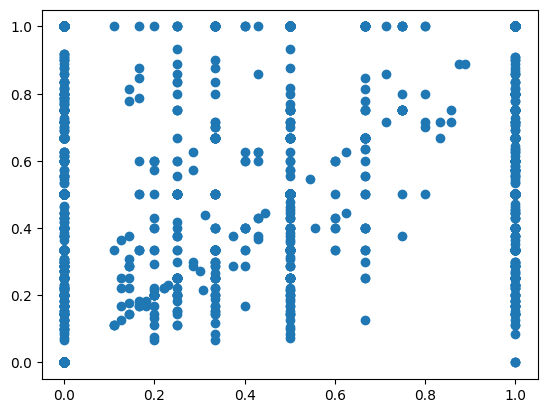

In [66]:
plt.scatter(content["miss_ratios_core0_detailled"][:,row,bank],content["miss_ratios_detailled"][:,row,bank])

In [67]:
F = Features()

In [68]:
G = GoalGenerator()

TypeError: GoalGenerator.__init__() missing 4 required positional arguments: 'num_bank', 'modules', 'H', and 'agent'